In [1]:
import numpy as np

In [2]:
import lal
import lalsimulation as lalsim

In [3]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({"font.size": 16})

In [4]:
def cyclic_time_shift(y, time_shift, delta_t):
    """
    y: real valued data to time shift
    time_shift: -val shift left, +ve values shift right. Time to shift y by.
    delta_t: time grid spacing for input y array.
    """
    ytilde = np.fft.fft(y)
    
    freqs = np.fft.fftfreq(len(ytilde), delta_t)
    
    fac = np.exp(-2*np.pi*1.j*freqs*time_shift)
    
    return np.real(np.fft.ifft(ytilde * fac))

In [5]:
def get_hp(
    m1=30, m2=30,
    S1x=0., S1y=0., S1z=0.,
    S2x=0, S2y=0., S2z=0.,
    distance=1e4,
    inclination=0.,
    phiRef=0.,
    longAscNodes=0.,
    eccentricity=0.,
    meanPerAno=0.,
    deltaT=2**-12,
    f_min=20.,
    f_ref=0.,
    LALparams=None,
    approximant=lalsim.SEOBNRv4_opt):

    hp, hc = lalsim.SimInspiralChooseTDWaveform(
            m1=m1*lal.MSUN_SI, m2=m2*lal.MSUN_SI,
            s1x=S1x, s1y=S1y, s1z=S1z,
            s2x=S2x, s2y=S2y, s2z=S2z,
            distance=distance,
            inclination=inclination,
            phiRef=phiRef,
            longAscNodes=longAscNodes,
            eccentricity=eccentricity,
            meanPerAno=meanPerAno,
            deltaT=deltaT,
            f_min=f_min,
            f_ref=f_ref,
            params=LALparams,
            approximant=approximant)

    dt = hp.deltaT
    epoch = np.float(hp.epoch)
#     times = np.arange(len(hp.data.data)) * dt + epoch
    times = np.arange(len(hp.data.data)) * dt
    
    hp = hp.data.data[:]
#     hc = hc.data.data[:]

    return times, cyclic_time_shift(hp, epoch, dt)

In [6]:
times, hp = get_hp()

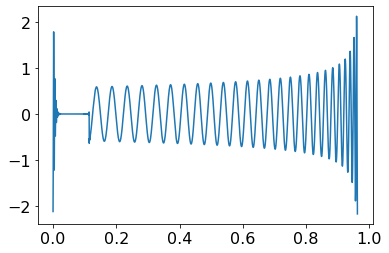

In [7]:
plt.figure()
plt.plot(times, hp)

In [8]:
hp_shift = cyclic_time_shift(hp, 0.2, times[1]-times[0])

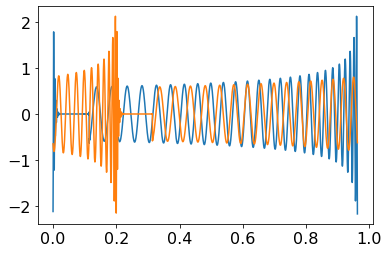

In [9]:
plt.figure()
plt.plot(times, hp)
plt.plot(times, hp_shift)

In [10]:
from scipy import signal

In [11]:
# Got this from Colm Talbot's thesis Appendix A.2 Window Choice.
def tukey_alpha(dt, T):
    """
    dt: roll-off parameter. The duration over which the windown rolls on and off at start and end.
    T: duration of segment
    """
    return 2*dt/T

In [12]:
roll_off = 0.1
duration = times[-1] - times[0]

In [13]:
alpha = tukey_alpha(roll_off, duration)
print(f"tukey alpha = {alpha}")

tukey alpha = 0.20776058838447883


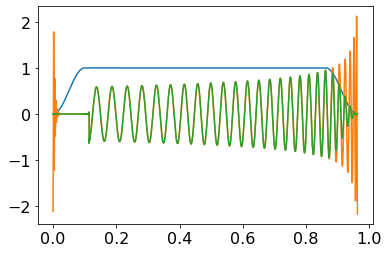

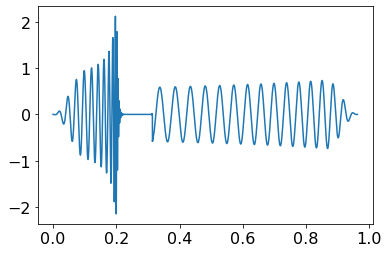

In [14]:
window = signal.tukey(len(hp), alpha)
plt.plot(times, window)
plt.plot(times, hp)
plt.plot(times, hp*window)

plt.figure()
plt.plot(times, hp_shift*window)

# using pycbc to recreate their likelihood 

## example using pycbc code to compute likelihood

In [ ]:
# example
# from docs
# http://pycbc.org/pycbc/latest/html/pycbc.inference.models.html#pycbc.inference.models.gaussian_noise.GaussianNoise

In [21]:
from pycbc import psd as pypsd
from pycbc.inference.models import GaussianNoise
from pycbc.waveform.generator import (FDomainDetFrameGenerator,
                                      FDomainCBCGenerator)

In [127]:
seglen = 4
sample_rate = 2048
N = seglen*sample_rate/2+1
fmin = 30.
static_params = {'approximant': 'IMRPhenomD', 'f_lower': fmin,
                 'mass1': 38.6, 'mass2': 29.3,
                 'spin1z': 0., 'spin2z': 0., 'ra': 1.37, 'dec': -1.26,
                 'polarization': 2.76, 'distance': 3*500.}
variable_params = ['tc']
tsig = 3.1

In [128]:
generator = FDomainDetFrameGenerator(
    FDomainCBCGenerator, 0., detectors=['H1', 'L1'],
    variable_args=variable_params,
    delta_f=1./seglen, **static_params)

In [129]:
signal = generator.generate(tc=tsig)

In [130]:
# dictionary of IFOs containing frequency series of the projected waveforms
signal

{'H1': <pycbc.types.frequencyseries.FrequencySeries at 0x1a244d3510>,
 'L1': <pycbc.types.frequencyseries.FrequencySeries at 0x1a244e1050>}

In [131]:
signa_H1_td = signal["H1"].to_timeseries()

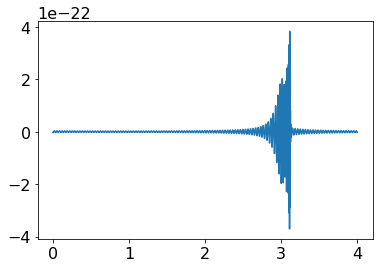

In [132]:
plt.figure()
plt.plot(signa_H1_td.sample_times, signa_H1_td)
# plt.xlim(tsig-0.2, tsig+0.1)

In [133]:
psd = pypsd.aLIGOZeroDetHighPower(N, 1./seglen, 20.)
psds = {'H1': psd, 'L1': psd}
low_frequency_cutoff = {'H1': fmin, 'L1': fmin}

/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/pycbc/psd/analytical.py:103: RuntimeWarning: forcing length argument to int
  warnings.warn('forcing length argument to int', RuntimeWarning)


In [134]:
model = GaussianNoise(variable_params, signal, low_frequency_cutoff,
                          psds=psds, static_params=static_params)

In [135]:
model.update(tc=tsig)

In [136]:
print('{:.2f}'.format(model.loglr))

282.43


In [137]:
print('{:.2f}'.format(model.logplr))

282.43


In [138]:
print(',\n'.join(['{}: {:.2f}'.format(s, v) for (s, v) in sorted(model.current_stats.items())]))

H1_cplx_loglr: 177.76+0.00j,
H1_optimal_snrsq: 355.52,
L1_cplx_loglr: 104.67+0.00j,
L1_optimal_snrsq: 209.35,
logjacobian: 0.00,
loglikelihood: 0.00,
loglr: 282.43,
logprior: 0.00


In [15]:
# https://pycbc.org/tutorials/3/3_WaveformMatchedFilter/

In [16]:
import pycbc.waveform

In [17]:
h1,h2 = pycbc.waveform.get_td_waveform(approximant="SEOBNRv4_opt", mass1=15, mass2=15, f_lower=15, delta_t=1/4096)

In [18]:
h1.duration

6.564453125

In [19]:
h1shift = h1.cyclic_time_shift(h1.start_time)

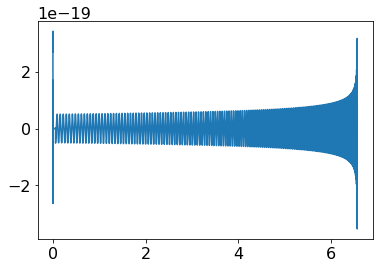

In [20]:
plt.figure()
plt.plot(h1shift.sample_times, h1shift)